#### 5 year Forecasting With ResellerSales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '0' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast
...,...,...,...,...
60914,2014-05-01,Reseller,316.860,Southwest
60915,2014-05-01,Reseller,809.760,Southwest
60916,2014-05-01,Reseller,3274.800,Southwest
60917,2014-05-01,Reseller,97.182,Southwest


In [4]:
df.OrderDate.max() 

Timestamp('2014-05-01 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [20]:
online_channel= df.loc[df['Region'] == 'Canada',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
14,2011-05-31,Reseller,809.7600,Canada
15,2011-05-31,Reseller,714.7043,Canada
16,2011-05-31,Reseller,1429.4086,Canada
17,2011-05-31,Reseller,20.7460,Canada
18,2011-05-31,Reseller,115.3616,Canada
...,...,...,...,...
60501,2014-05-01,Reseller,21.5760,Canada
60502,2014-05-01,Reseller,72.9988,Canada
60503,2014-05-01,Reseller,32.3640,Canada
60504,2014-05-01,Reseller,144.0000,Canada


### Data Preprocessing

In [21]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [22]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,115360.8960
1,2011-07-01,317093.9349
2,2011-08-01,205640.8745
3,2011-08-31,235009.2685
4,2011-10-01,382517.2924
5,2011-10-31,258664.2034
6,2011-12-01,163893.3668
7,2012-01-01,276632.2611
8,2012-01-29,335346.0299
9,2012-02-29,228173.1575


### Indexing with Time Series Data

In [23]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-07-01', '2011-08-01', '2011-08-31',
               '2011-10-01', '2011-10-31', '2011-12-01', '2012-01-01',
               '2012-01-29', '2012-02-29', '2012-03-30', '2012-04-30',
               '2012-05-30', '2012-06-30', '2012-07-31', '2012-08-30',
               '2012-09-30', '2012-10-30', '2012-11-30', '2012-12-31',
               '2013-01-28', '2013-02-28', '2013-03-30', '2013-04-30',
               '2013-05-30', '2013-06-30', '2013-07-31', '2013-08-30',
               '2013-09-30', '2013-10-30', '2013-11-30', '2013-12-31',
               '2014-01-29', '2014-03-01', '2014-03-31', '2014-05-01'],
              dtype='datetime64[ns]', name='OrderDate', freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [24]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [25]:
y['2014':]

OrderDate
2014-01-01    465030.72460
2014-02-01    391815.10925
2014-03-01    391815.10925
2014-04-01    587578.19710
2014-05-01    587578.19710
Freq: MS, Name: Total_Sales, dtype: float64

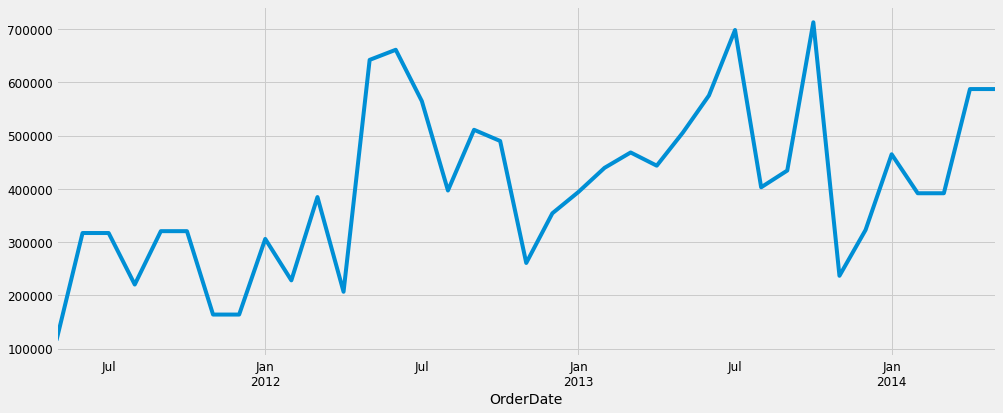

In [26]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

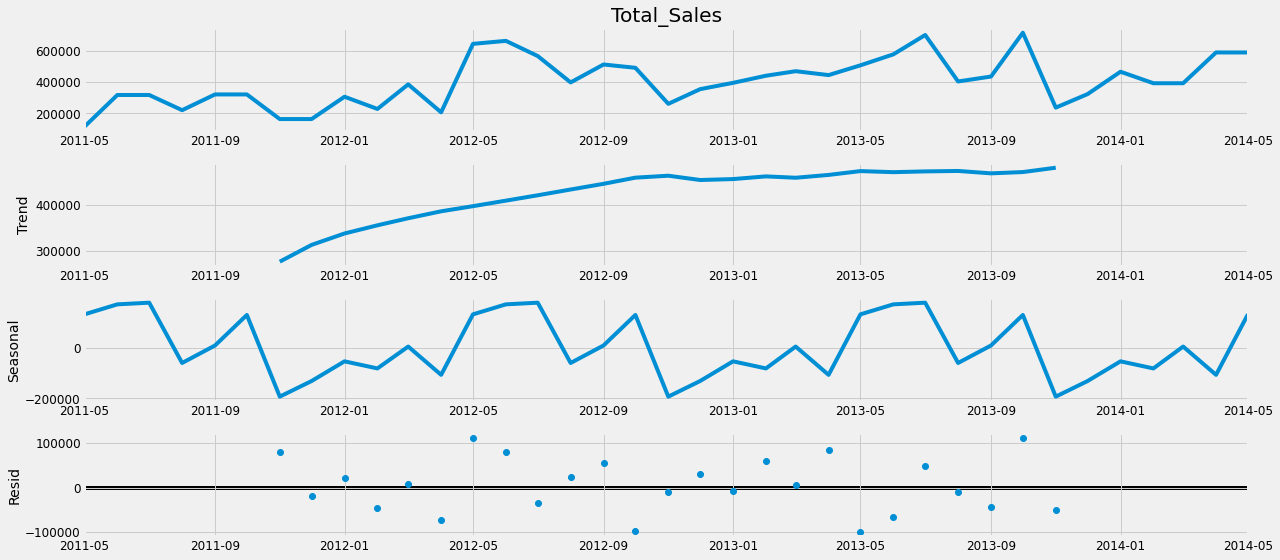

In [27]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [29]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1039.6294446892075
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1260036.8221211592
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:643.8825494234303
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:317.1559662765464
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:677.7905368644152
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:640.9332454072419
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:341.1478248377579
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:318.68679562822314
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:992.9758554990754
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1009544.5090940059
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:611.2424026305769
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:289.7201826174413
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:705.5081657340136
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:650.3991787576213
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:341.00430267920933
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:290.7984045000477
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:941.1259873729995
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:617.2024576642202
ARIMA

 ### Fitting an ARIMA Time Series Model

In [30]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3470      0.959     -0.362      0.717      -2.227       1.533
ma.L1         -0.7213      0.573     -1.259      0.208      -1.844       0.402
ar.S.L12      -0.1789     24.930     -0.007      0.994     -49.040      48.683
ma.S.L12       0.1424     25.606      0.006      0.996     -50.044      50.328
sigma2      1.535e+10   1.92e-08   7.99e+17      0.000    1.54e+10    1.54e+10


### Validating forecasts

In [32]:
pred = results.get_prediction(start=pd.to_datetime('2011-06-1'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()



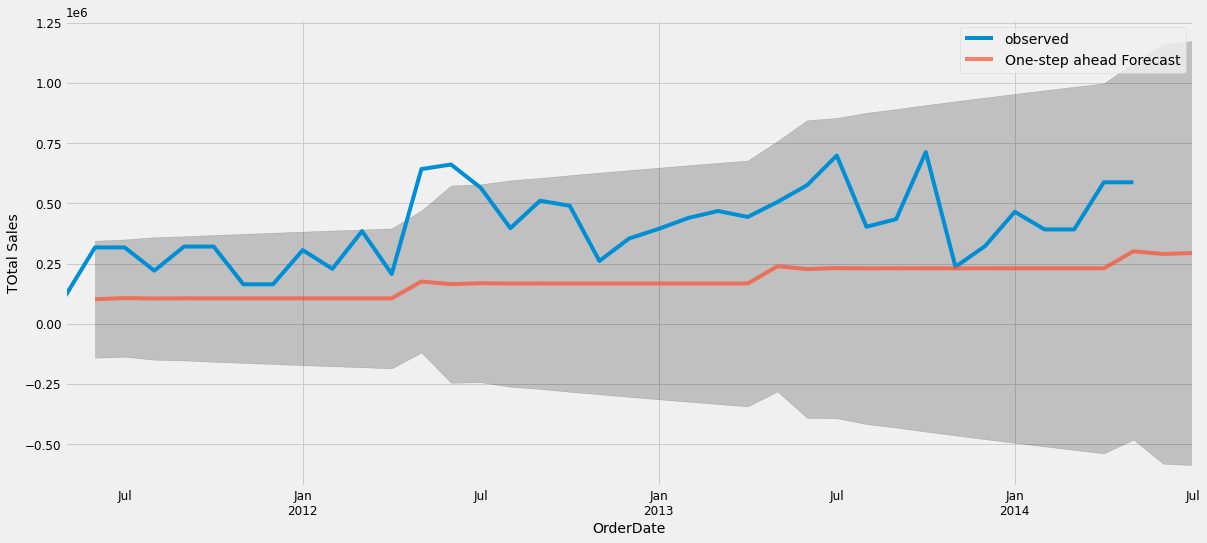

In [33]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()

plt.show()

In [34]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 63441439621.21


In [35]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 251875.84


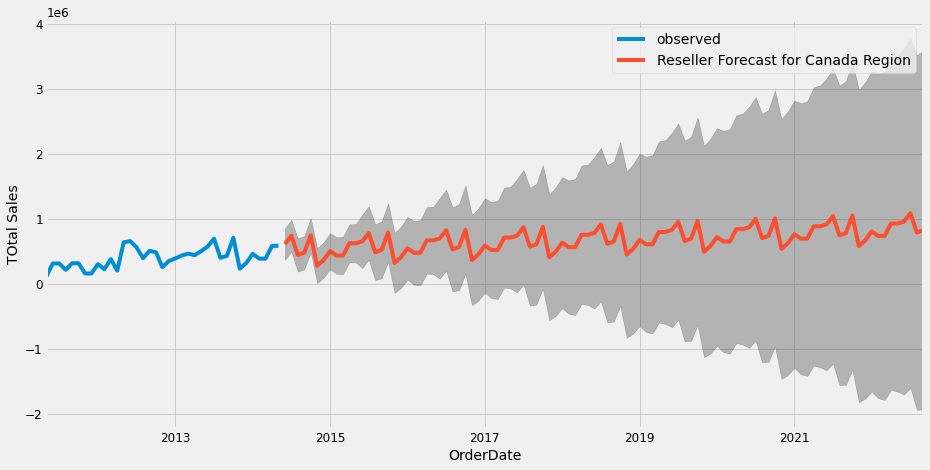

In [37]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Reseller Forecast for Canada Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()
plt.show()